# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

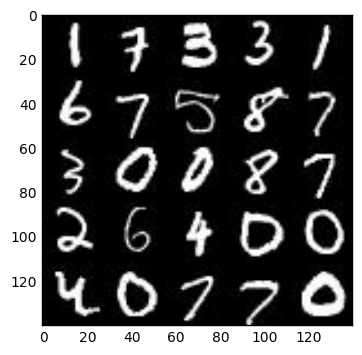

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

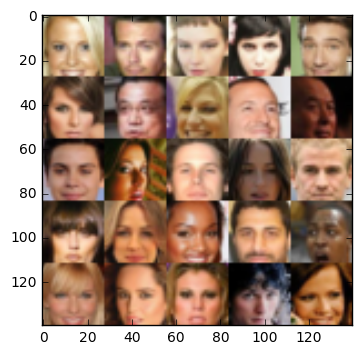

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [80]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [81]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name = 'learning_rate' )
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [157]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.05
    with tf.variable_scope('discriminator', reuse = reuse):
        
        x1 = tf.layers.conv2d(images,
                              64, 
                              5, 
                              strides = 2, 
                              padding = 'same', 
                              kernel_initializer= tf.contrib.layers.xavier_initializer())
        r1 = tf.maximum( alpha * x1, x1)
        
        x2 = tf.layers.conv2d(r1, 
                              128, 
                              5, 
                              strides = 2, 
                              padding = 'same', 
                              kernel_initializer= tf.contrib.layers.xavier_initializer())
        
        bn2 = tf.layers.batch_normalization(x2, training = True)
        r2 = tf.maximum( alpha * bn2, bn2)
        x3 = tf.layers.conv2d(r2, 
                              256,
                              5, 
                              strides = 2, 
                              padding = 'same', 
                              kernel_initializer= tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training = True)
        r3 = tf.maximum( alpha * bn3, bn3)
        
        flat = tf.reshape(r3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [158]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.05
    with tf.variable_scope( 'generator', reuse = not is_train):
        
        x1 = tf.layers.dense(z, 7*7*512)
        
        #reshape for conv stack
        x1 = tf.reshape(x1, [-1, 7, 7, 512])
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum( alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 
                                        256, 
                                        5, 
                                        strides = 2, 
                                        padding = 'same',
                                        kernel_initializer= tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum( alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 
                                        128, 
                                        5, 
                                        strides = 2, 
                                        padding = 'same', 
                                        kernel_initializer= tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum( alpha * x3, x3)
        logits = tf.layers.conv2d_transpose(x3, 
                                            out_channel_dim, 
                                            5, 
                                            strides = 1, 
                                            padding = 'same', 
                                            kernel_initializer= tf.contrib.layers.xavier_initializer())
        #logits = tf.image.resize_images(logits, (28, 28))
        logits = tf.tanh(logits)
    return logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [159]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(images = input_real)
    d_model_fake, d_logits_fake = discriminator(images = g_model, reuse = True)
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                                        labels = tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                        labels = tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                   labels = tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [164]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 =beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [165]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [166]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver(var_list = g_vars)
    steps = 0
   
    if (data_image_mode == "L"):
        out_channel_dim = 1
    else:
        out_channel_dim = 3
        
    print_every = 10
    
    show_every = 100
    samples, losses = [],[]
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], 
                                                       data_shape[2], 
                                                       data_shape[3], 
                                                       z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(inputs_real, 
                                inputs_z, 
                                out_channel_dim)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_images = batch_images *2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images,
                                               inputs_z: batch_z})       
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, 
                                               inputs_real: batch_images})
                
  
                

                    
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format((epoch_i+1), epoch_count),
                          "Discriminator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    #losses.append((train_loss_d,train_loss_g))
                    
                if steps % show_every == 0:
                    
                    show_generator_output(sess, 9, inputs_z, data_shape[3], 
                                                        data_image_mode)
                    
                    
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4204 Generator Loss: 1.2338
Epoch 1/2... Discriminator Loss: 0.1216 Generator Loss: 7.3082
Epoch 1/2... Discriminator Loss: 0.4232 Generator Loss: 2.2320
Epoch 1/2... Discriminator Loss: 1.0721 Generator Loss: 2.0098
Epoch 1/2... Discriminator Loss: 0.6002 Generator Loss: 1.4260
Epoch 1/2... Discriminator Loss: 0.2269 Generator Loss: 3.9823
Epoch 1/2... Discriminator Loss: 0.5032 Generator Loss: 1.9044
Epoch 1/2... Discriminator Loss: 0.9155 Generator Loss: 1.5061
Epoch 1/2... Discriminator Loss: 0.9492 Generator Loss: 1.4003
Epoch 1/2... Discriminator Loss: 1.1806 Generator Loss: 1.3938


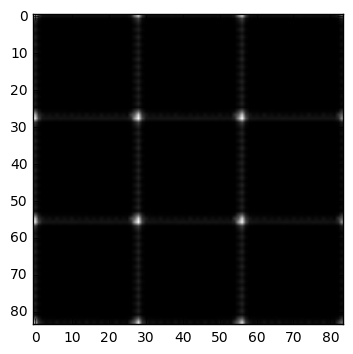

Epoch 1/2... Discriminator Loss: 1.0595 Generator Loss: 0.9874
Epoch 1/2... Discriminator Loss: 1.4012 Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 0.9270 Generator Loss: 1.4473
Epoch 1/2... Discriminator Loss: 1.1795 Generator Loss: 1.5682
Epoch 1/2... Discriminator Loss: 1.0251 Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 0.9004 Generator Loss: 0.9970
Epoch 1/2... Discriminator Loss: 1.0835 Generator Loss: 1.8876
Epoch 1/2... Discriminator Loss: 1.0505 Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 1.0743 Generator Loss: 0.6211
Epoch 1/2... Discriminator Loss: 0.9633 Generator Loss: 1.2315


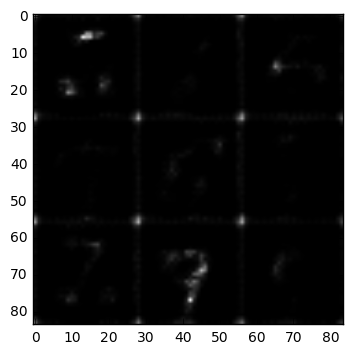

Epoch 1/2... Discriminator Loss: 0.9502 Generator Loss: 1.0109
Epoch 1/2... Discriminator Loss: 0.9092 Generator Loss: 1.4154
Epoch 1/2... Discriminator Loss: 0.9300 Generator Loss: 1.2098
Epoch 1/2... Discriminator Loss: 1.2075 Generator Loss: 1.6473
Epoch 1/2... Discriminator Loss: 0.9784 Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 1.0342 Generator Loss: 0.7518
Epoch 1/2... Discriminator Loss: 1.0764 Generator Loss: 2.3109
Epoch 1/2... Discriminator Loss: 0.9918 Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 1.2091 Generator Loss: 2.2791
Epoch 1/2... Discriminator Loss: 1.0850 Generator Loss: 1.0429


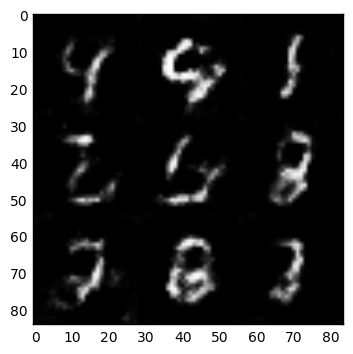

Epoch 1/2... Discriminator Loss: 0.9591 Generator Loss: 1.1211
Epoch 1/2... Discriminator Loss: 1.0404 Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 0.9563 Generator Loss: 1.3842
Epoch 1/2... Discriminator Loss: 1.1503 Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 0.9732 Generator Loss: 1.4745
Epoch 1/2... Discriminator Loss: 0.9990 Generator Loss: 1.4908
Epoch 1/2... Discriminator Loss: 1.1932 Generator Loss: 0.5384
Epoch 1/2... Discriminator Loss: 1.0440 Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 1.0555 Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.1452 Generator Loss: 0.6257


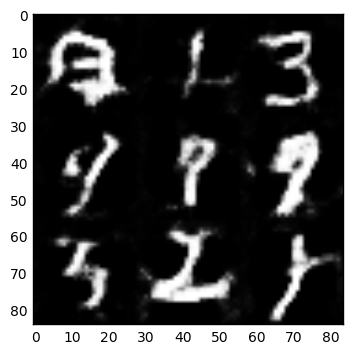

Epoch 1/2... Discriminator Loss: 1.2934 Generator Loss: 0.4363
Epoch 1/2... Discriminator Loss: 1.0346 Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 0.9825 Generator Loss: 1.6337
Epoch 1/2... Discriminator Loss: 0.9735 Generator Loss: 0.7863
Epoch 1/2... Discriminator Loss: 1.2840 Generator Loss: 0.4364
Epoch 1/2... Discriminator Loss: 1.0348 Generator Loss: 1.1101
Epoch 1/2... Discriminator Loss: 1.0692 Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 0.9160 Generator Loss: 1.1787
Epoch 1/2... Discriminator Loss: 0.9377 Generator Loss: 0.9821
Epoch 1/2... Discriminator Loss: 0.9595 Generator Loss: 1.2916


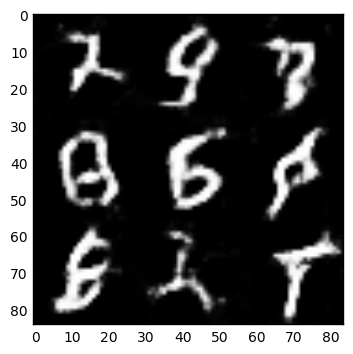

Epoch 1/2... Discriminator Loss: 0.9812 Generator Loss: 0.7895
Epoch 1/2... Discriminator Loss: 1.1411 Generator Loss: 1.7673
Epoch 1/2... Discriminator Loss: 0.9688 Generator Loss: 1.2305
Epoch 1/2... Discriminator Loss: 0.9723 Generator Loss: 0.9171
Epoch 1/2... Discriminator Loss: 1.0966 Generator Loss: 0.5691
Epoch 1/2... Discriminator Loss: 1.1611 Generator Loss: 0.5631
Epoch 1/2... Discriminator Loss: 1.0339 Generator Loss: 0.7748
Epoch 1/2... Discriminator Loss: 0.9169 Generator Loss: 1.0599
Epoch 1/2... Discriminator Loss: 0.8811 Generator Loss: 1.0111
Epoch 1/2... Discriminator Loss: 1.1492 Generator Loss: 0.5709


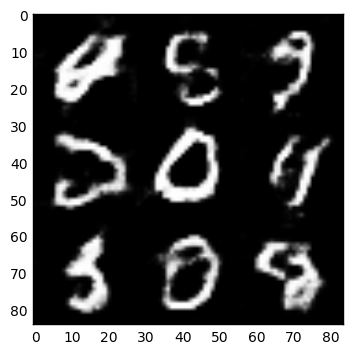

Epoch 2/2... Discriminator Loss: 1.1434 Generator Loss: 0.6050
Epoch 2/2... Discriminator Loss: 1.0662 Generator Loss: 0.6603
Epoch 2/2... Discriminator Loss: 1.8898 Generator Loss: 0.2044
Epoch 2/2... Discriminator Loss: 1.2521 Generator Loss: 0.4461
Epoch 2/2... Discriminator Loss: 1.1190 Generator Loss: 0.5325
Epoch 2/2... Discriminator Loss: 0.9314 Generator Loss: 1.0528
Epoch 2/2... Discriminator Loss: 0.9316 Generator Loss: 0.8439
Epoch 2/2... Discriminator Loss: 0.9263 Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 1.1534 Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 0.9584 Generator Loss: 1.0571


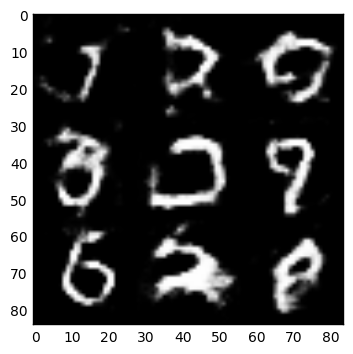

Epoch 2/2... Discriminator Loss: 0.9108 Generator Loss: 0.9833
Epoch 2/2... Discriminator Loss: 1.0703 Generator Loss: 1.5324
Epoch 2/2... Discriminator Loss: 0.9622 Generator Loss: 0.8174
Epoch 2/2... Discriminator Loss: 0.9424 Generator Loss: 1.6815
Epoch 2/2... Discriminator Loss: 0.9640 Generator Loss: 0.9593
Epoch 2/2... Discriminator Loss: 1.3241 Generator Loss: 0.4082
Epoch 2/2... Discriminator Loss: 0.9284 Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 0.9857 Generator Loss: 0.7403
Epoch 2/2... Discriminator Loss: 2.5190 Generator Loss: 0.1251
Epoch 2/2... Discriminator Loss: 1.0643 Generator Loss: 0.6505


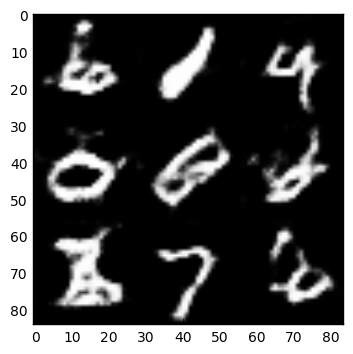

Epoch 2/2... Discriminator Loss: 0.9612 Generator Loss: 0.7418
Epoch 2/2... Discriminator Loss: 0.7796 Generator Loss: 1.3488
Epoch 2/2... Discriminator Loss: 0.9636 Generator Loss: 0.9859
Epoch 2/2... Discriminator Loss: 0.9406 Generator Loss: 1.3184
Epoch 2/2... Discriminator Loss: 1.1937 Generator Loss: 0.4946
Epoch 2/2... Discriminator Loss: 2.2808 Generator Loss: 0.1447
Epoch 2/2... Discriminator Loss: 1.0229 Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 1.0656 Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 0.9566 Generator Loss: 1.0401
Epoch 2/2... Discriminator Loss: 2.0960 Generator Loss: 3.1493


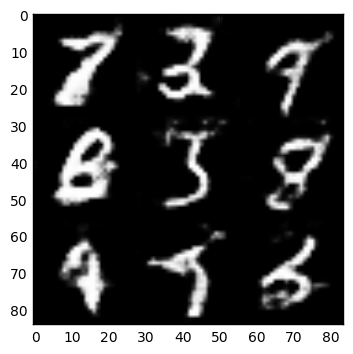

Epoch 2/2... Discriminator Loss: 0.9676 Generator Loss: 0.9067
Epoch 2/2... Discriminator Loss: 0.9887 Generator Loss: 0.8734
Epoch 2/2... Discriminator Loss: 1.1256 Generator Loss: 0.5643
Epoch 2/2... Discriminator Loss: 1.0625 Generator Loss: 0.6618
Epoch 2/2... Discriminator Loss: 0.8590 Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 0.8462 Generator Loss: 1.4291
Epoch 2/2... Discriminator Loss: 0.8979 Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 1.4880 Generator Loss: 0.3637
Epoch 2/2... Discriminator Loss: 0.9750 Generator Loss: 1.8591
Epoch 2/2... Discriminator Loss: 0.9405 Generator Loss: 0.9088


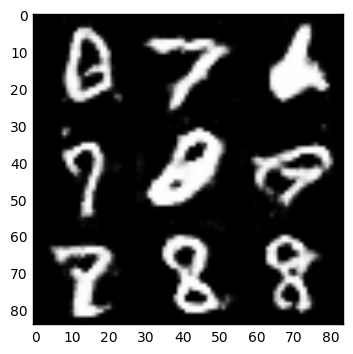

Epoch 2/2... Discriminator Loss: 0.9470 Generator Loss: 0.7608
Epoch 2/2... Discriminator Loss: 0.9208 Generator Loss: 1.2205
Epoch 2/2... Discriminator Loss: 0.8914 Generator Loss: 1.0360
Epoch 2/2... Discriminator Loss: 0.8485 Generator Loss: 0.9736
Epoch 2/2... Discriminator Loss: 0.9010 Generator Loss: 0.8892
Epoch 2/2... Discriminator Loss: 0.8610 Generator Loss: 1.4385
Epoch 2/2... Discriminator Loss: 1.0347 Generator Loss: 0.6338
Epoch 2/2... Discriminator Loss: 0.9021 Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 1.0097 Generator Loss: 0.6312
Epoch 2/2... Discriminator Loss: 0.9077 Generator Loss: 1.1752


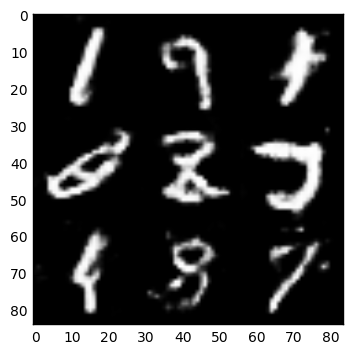

Epoch 2/2... Discriminator Loss: 0.8715 Generator Loss: 1.1152
Epoch 2/2... Discriminator Loss: 0.8466 Generator Loss: 1.2131
Epoch 2/2... Discriminator Loss: 1.1455 Generator Loss: 0.5571
Epoch 2/2... Discriminator Loss: 1.1691 Generator Loss: 0.8195
Epoch 2/2... Discriminator Loss: 1.0402 Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 0.9389 Generator Loss: 0.8432
Epoch 2/2... Discriminator Loss: 0.9370 Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 0.8628 Generator Loss: 1.0483
Epoch 2/2... Discriminator Loss: 0.7736 Generator Loss: 1.2492
Epoch 2/2... Discriminator Loss: 1.2830 Generator Loss: 0.4295


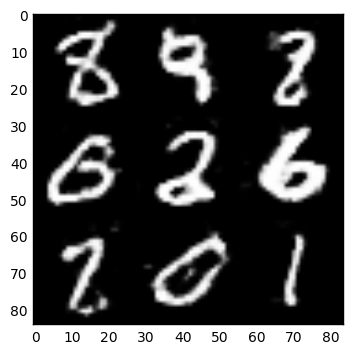

In [167]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7581 Generator Loss: 1.0724
Epoch 1/1... Discriminator Loss: 0.7386 Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 0.3781 Generator Loss: 1.6922
Epoch 1/1... Discriminator Loss: 0.2877 Generator Loss: 2.4813
Epoch 1/1... Discriminator Loss: 0.7525 Generator Loss: 1.2856
Epoch 1/1... Discriminator Loss: 0.8877 Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 1.0561 Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 0.7137 Generator Loss: 3.5040
Epoch 1/1... Discriminator Loss: 0.8400 Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 0.2484 Generator Loss: 3.3959


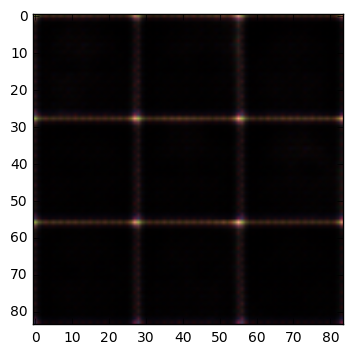

Epoch 1/1... Discriminator Loss: 0.6115 Generator Loss: 1.1069
Epoch 1/1... Discriminator Loss: 0.1881 Generator Loss: 2.8248
Epoch 1/1... Discriminator Loss: 0.4600 Generator Loss: 1.3719
Epoch 1/1... Discriminator Loss: 0.2603 Generator Loss: 2.6230
Epoch 1/1... Discriminator Loss: 0.4727 Generator Loss: 5.4289
Epoch 1/1... Discriminator Loss: 1.1693 Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 0.2982 Generator Loss: 2.8870
Epoch 1/1... Discriminator Loss: 1.2765 Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 0.2978 Generator Loss: 2.0026
Epoch 1/1... Discriminator Loss: 0.5077 Generator Loss: 1.3014


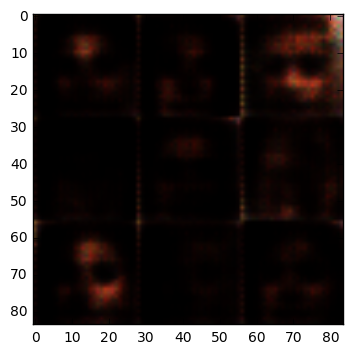

Epoch 1/1... Discriminator Loss: 0.8110 Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 0.5898 Generator Loss: 1.2796
Epoch 1/1... Discriminator Loss: 0.9366 Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 0.8561 Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 2.0466 Generator Loss: 0.2350
Epoch 1/1... Discriminator Loss: 0.9195 Generator Loss: 2.8244
Epoch 1/1... Discriminator Loss: 0.4922 Generator Loss: 7.6684
Epoch 1/1... Discriminator Loss: 0.2244 Generator Loss: 4.1648
Epoch 1/1... Discriminator Loss: 0.5865 Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 0.5954 Generator Loss: 1.0855


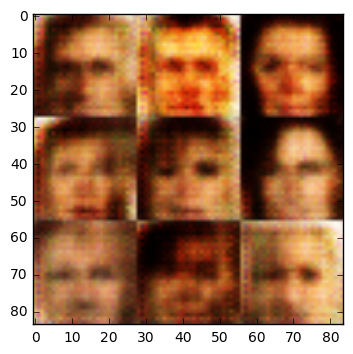

Epoch 1/1... Discriminator Loss: 0.9402 Generator Loss: 1.3496
Epoch 1/1... Discriminator Loss: 0.7149 Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 1.3966 Generator Loss: 0.4770
Epoch 1/1... Discriminator Loss: 1.0556 Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 0.4852 Generator Loss: 1.9071
Epoch 1/1... Discriminator Loss: 1.8629 Generator Loss: 0.2458
Epoch 1/1... Discriminator Loss: 0.5089 Generator Loss: 3.2456
Epoch 1/1... Discriminator Loss: 0.6793 Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.3263 Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.0608 Generator Loss: 1.3351


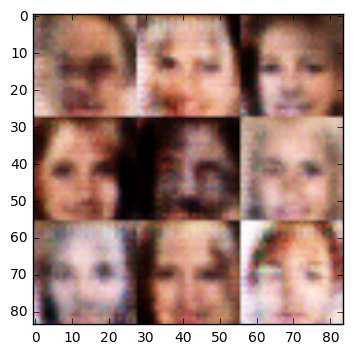

Epoch 1/1... Discriminator Loss: 1.2937 Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.0743 Generator Loss: 1.0770
Epoch 1/1... Discriminator Loss: 1.3696 Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 1.2543 Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.7082 Generator Loss: 0.3368
Epoch 1/1... Discriminator Loss: 0.9057 Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 0.4461 Generator Loss: 2.2832
Epoch 1/1... Discriminator Loss: 0.8982 Generator Loss: 2.4394
Epoch 1/1... Discriminator Loss: 1.2348 Generator Loss: 5.1333
Epoch 1/1... Discriminator Loss: 1.3174 Generator Loss: 0.7757


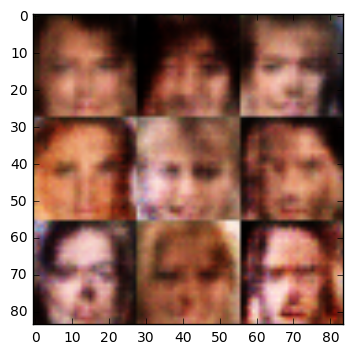

Epoch 1/1... Discriminator Loss: 1.2067 Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 0.7974 Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 1.0990 Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.0667 Generator Loss: 1.4204
Epoch 1/1... Discriminator Loss: 0.4019 Generator Loss: 3.1074
Epoch 1/1... Discriminator Loss: 1.5871 Generator Loss: 1.8331
Epoch 1/1... Discriminator Loss: 1.2434 Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.2367 Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 0.9627 Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 0.9376 Generator Loss: 1.4106


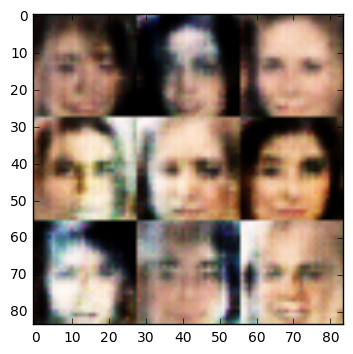

Epoch 1/1... Discriminator Loss: 1.1974 Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.2699 Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 2.1342 Generator Loss: 0.1741
Epoch 1/1... Discriminator Loss: 0.6090 Generator Loss: 1.5485
Epoch 1/1... Discriminator Loss: 0.8615 Generator Loss: 1.3996
Epoch 1/1... Discriminator Loss: 0.9386 Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 0.6004 Generator Loss: 1.4476
Epoch 1/1... Discriminator Loss: 1.4917 Generator Loss: 0.3999
Epoch 1/1... Discriminator Loss: 1.9044 Generator Loss: 0.2174
Epoch 1/1... Discriminator Loss: 1.7309 Generator Loss: 0.2866


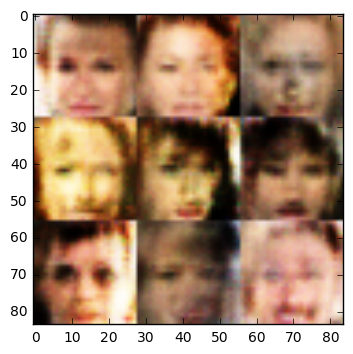

Epoch 1/1... Discriminator Loss: 1.8936 Generator Loss: 0.2466
Epoch 1/1... Discriminator Loss: 1.2375 Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 0.8384 Generator Loss: 1.7365
Epoch 1/1... Discriminator Loss: 1.2347 Generator Loss: 0.4383
Epoch 1/1... Discriminator Loss: 1.0628 Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 0.5210 Generator Loss: 1.5408
Epoch 1/1... Discriminator Loss: 0.6814 Generator Loss: 1.6453
Epoch 1/1... Discriminator Loss: 1.7599 Generator Loss: 0.2457
Epoch 1/1... Discriminator Loss: 0.9942 Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 0.4332 Generator Loss: 1.6568


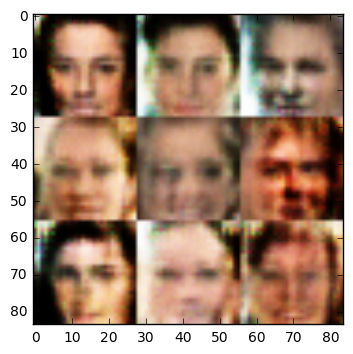

Epoch 1/1... Discriminator Loss: 0.9795 Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 0.4230 Generator Loss: 2.2692
Epoch 1/1... Discriminator Loss: 2.2601 Generator Loss: 0.1752
Epoch 1/1... Discriminator Loss: 1.8684 Generator Loss: 0.2580
Epoch 1/1... Discriminator Loss: 0.7650 Generator Loss: 1.3913
Epoch 1/1... Discriminator Loss: 0.7748 Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.2121 Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 0.9528 Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 0.7971 Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 1.3921 Generator Loss: 0.3779


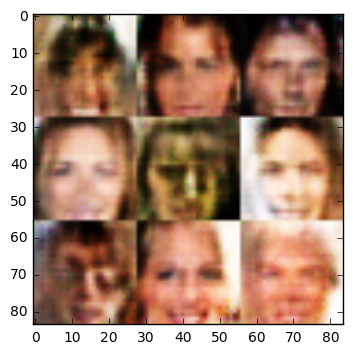

Epoch 1/1... Discriminator Loss: 1.2779 Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 0.4678 Generator Loss: 1.4278
Epoch 1/1... Discriminator Loss: 0.4588 Generator Loss: 2.7074
Epoch 1/1... Discriminator Loss: 0.4747 Generator Loss: 2.1607
Epoch 1/1... Discriminator Loss: 1.2320 Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 0.5394 Generator Loss: 2.9205
Epoch 1/1... Discriminator Loss: 1.0249 Generator Loss: 2.0883
Epoch 1/1... Discriminator Loss: 0.4807 Generator Loss: 2.2523
Epoch 1/1... Discriminator Loss: 0.5265 Generator Loss: 1.9099
Epoch 1/1... Discriminator Loss: 1.2368 Generator Loss: 1.3587


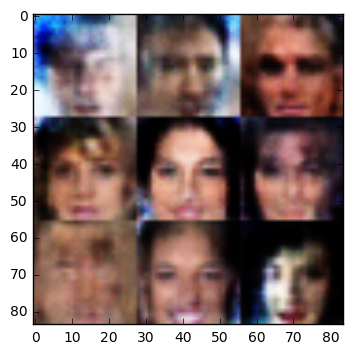

Epoch 1/1... Discriminator Loss: 1.5360 Generator Loss: 0.3313
Epoch 1/1... Discriminator Loss: 0.5292 Generator Loss: 2.1897
Epoch 1/1... Discriminator Loss: 1.2355 Generator Loss: 1.3602
Epoch 1/1... Discriminator Loss: 1.6478 Generator Loss: 0.2927
Epoch 1/1... Discriminator Loss: 1.3737 Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.0308 Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 0.8894 Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 0.9766 Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 0.4574 Generator Loss: 2.5014
Epoch 1/1... Discriminator Loss: 2.1702 Generator Loss: 1.7848


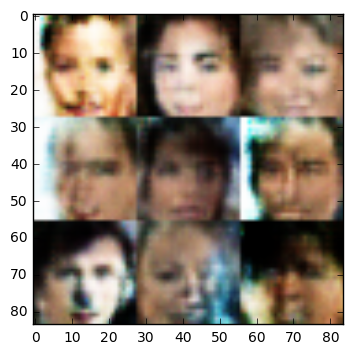

Epoch 1/1... Discriminator Loss: 1.2498 Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 0.9542 Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 0.3452 Generator Loss: 1.7985
Epoch 1/1... Discriminator Loss: 1.2270 Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 0.9368 Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 0.5800 Generator Loss: 2.1260
Epoch 1/1... Discriminator Loss: 1.4709 Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 0.9955 Generator Loss: 1.6673
Epoch 1/1... Discriminator Loss: 0.4952 Generator Loss: 1.9673
Epoch 1/1... Discriminator Loss: 1.4173 Generator Loss: 0.4097


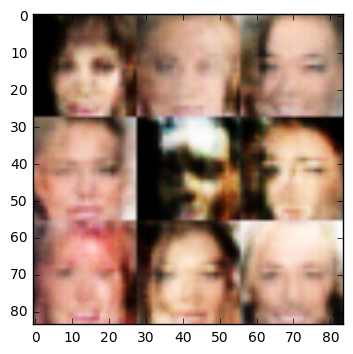

Epoch 1/1... Discriminator Loss: 1.3198 Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 0.5472 Generator Loss: 1.5506
Epoch 1/1... Discriminator Loss: 1.4867 Generator Loss: 0.3713
Epoch 1/1... Discriminator Loss: 0.3540 Generator Loss: 2.0889
Epoch 1/1... Discriminator Loss: 0.6779 Generator Loss: 1.7435
Epoch 1/1... Discriminator Loss: 1.1119 Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.0738 Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3645 Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.0022 Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 0.9328 Generator Loss: 0.7260


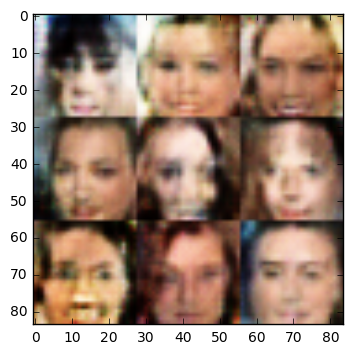

Epoch 1/1... Discriminator Loss: 1.2828 Generator Loss: 0.4558
Epoch 1/1... Discriminator Loss: 1.2794 Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 0.7852 Generator Loss: 1.2685
Epoch 1/1... Discriminator Loss: 0.7172 Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 0.9662 Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.3126 Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 1.1390 Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 0.8491 Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 0.5846 Generator Loss: 2.5191
Epoch 1/1... Discriminator Loss: 1.5796 Generator Loss: 0.3234


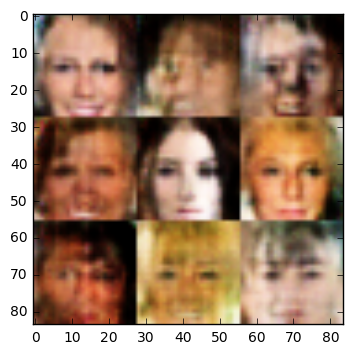

Epoch 1/1... Discriminator Loss: 1.4766 Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.0884 Generator Loss: 2.0750
Epoch 1/1... Discriminator Loss: 0.9576 Generator Loss: 2.6578
Epoch 1/1... Discriminator Loss: 1.5282 Generator Loss: 2.3332
Epoch 1/1... Discriminator Loss: 1.9495 Generator Loss: 0.1909
Epoch 1/1... Discriminator Loss: 0.7676 Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 1.0881 Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 0.5416 Generator Loss: 2.3881
Epoch 1/1... Discriminator Loss: 1.0889 Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 0.7020 Generator Loss: 0.9069


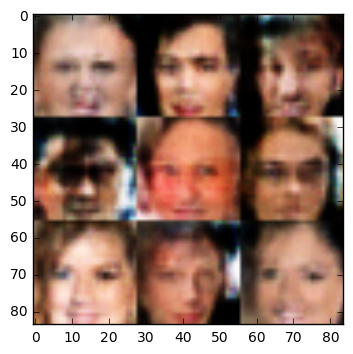

Epoch 1/1... Discriminator Loss: 0.6705 Generator Loss: 1.8308
Epoch 1/1... Discriminator Loss: 1.3675 Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 0.6921 Generator Loss: 1.3721
Epoch 1/1... Discriminator Loss: 0.6008 Generator Loss: 1.3713
Epoch 1/1... Discriminator Loss: 1.3253 Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 0.3993 Generator Loss: 2.6603
Epoch 1/1... Discriminator Loss: 0.4275 Generator Loss: 1.8905
Epoch 1/1... Discriminator Loss: 1.4737 Generator Loss: 0.4102
Epoch 1/1... Discriminator Loss: 0.9351 Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 0.6525 Generator Loss: 1.0930


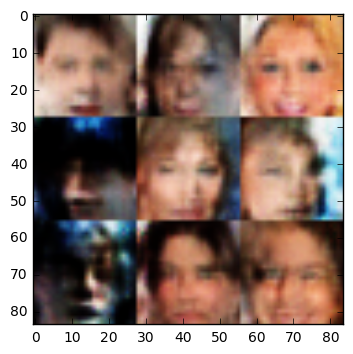

Epoch 1/1... Discriminator Loss: 1.3468 Generator Loss: 2.3915
Epoch 1/1... Discriminator Loss: 0.7733 Generator Loss: 2.7632
Epoch 1/1... Discriminator Loss: 0.8400 Generator Loss: 2.1236
Epoch 1/1... Discriminator Loss: 0.7627 Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.1542 Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 0.9411 Generator Loss: 2.3222
Epoch 1/1... Discriminator Loss: 1.0127 Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 0.8634 Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.1073 Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 0.6251 Generator Loss: 1.1397


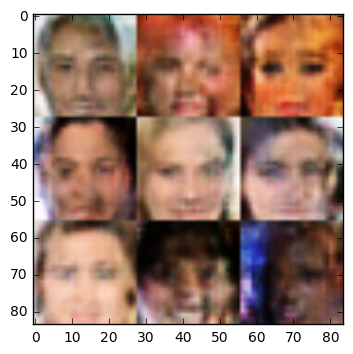

Epoch 1/1... Discriminator Loss: 0.8697 Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 1.0689 Generator Loss: 1.6640
Epoch 1/1... Discriminator Loss: 0.3552 Generator Loss: 2.3321
Epoch 1/1... Discriminator Loss: 1.1832 Generator Loss: 3.0939
Epoch 1/1... Discriminator Loss: 0.9143 Generator Loss: 1.1480
Epoch 1/1... Discriminator Loss: 0.9283 Generator Loss: 1.4082
Epoch 1/1... Discriminator Loss: 0.7489 Generator Loss: 1.8984
Epoch 1/1... Discriminator Loss: 1.3589 Generator Loss: 0.3692
Epoch 1/1... Discriminator Loss: 2.2801 Generator Loss: 2.1607
Epoch 1/1... Discriminator Loss: 0.8563 Generator Loss: 1.2940


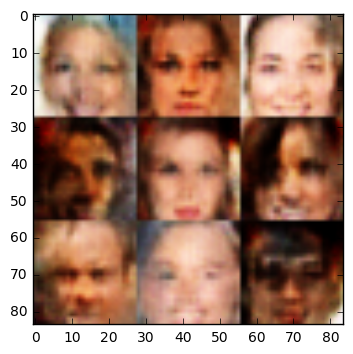

Epoch 1/1... Discriminator Loss: 0.6566 Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 1.3612 Generator Loss: 1.8372
Epoch 1/1... Discriminator Loss: 0.1446 Generator Loss: 3.9735
Epoch 1/1... Discriminator Loss: 0.4864 Generator Loss: 1.7110
Epoch 1/1... Discriminator Loss: 0.7263 Generator Loss: 4.2238
Epoch 1/1... Discriminator Loss: 0.6905 Generator Loss: 1.5034
Epoch 1/1... Discriminator Loss: 1.1869 Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 1.2378 Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.3435 Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 0.6115 Generator Loss: 1.9422


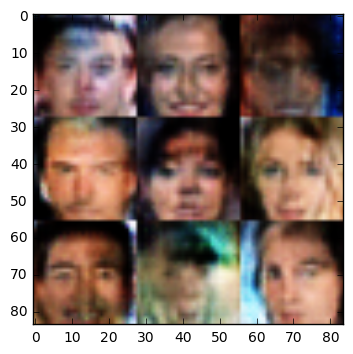

Epoch 1/1... Discriminator Loss: 0.5629 Generator Loss: 1.4841
Epoch 1/1... Discriminator Loss: 1.2065 Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.3952 Generator Loss: 0.3636
Epoch 1/1... Discriminator Loss: 0.8526 Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.0261 Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 0.7829 Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 0.7936 Generator Loss: 1.9719
Epoch 1/1... Discriminator Loss: 1.3775 Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 0.9689 Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 0.7502 Generator Loss: 3.1677


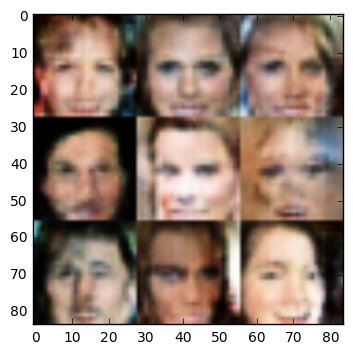

Epoch 1/1... Discriminator Loss: 0.5627 Generator Loss: 2.7412
Epoch 1/1... Discriminator Loss: 1.4398 Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 0.7137 Generator Loss: 1.1945
Epoch 1/1... Discriminator Loss: 0.9508 Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4409 Generator Loss: 0.3661
Epoch 1/1... Discriminator Loss: 1.3767 Generator Loss: 2.0742
Epoch 1/1... Discriminator Loss: 1.1225 Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 0.9531 Generator Loss: 1.4815
Epoch 1/1... Discriminator Loss: 1.0548 Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.5012 Generator Loss: 0.3687


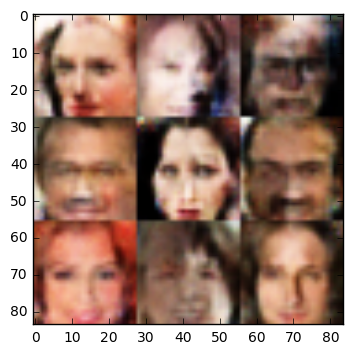

Epoch 1/1... Discriminator Loss: 1.1746 Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.4858 Generator Loss: 0.3940
Epoch 1/1... Discriminator Loss: 1.4226 Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.0557 Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 0.7112 Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.9857 Generator Loss: 0.1879
Epoch 1/1... Discriminator Loss: 0.2847 Generator Loss: 2.0122
Epoch 1/1... Discriminator Loss: 1.4286 Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 0.7862 Generator Loss: 1.5456
Epoch 1/1... Discriminator Loss: 0.8576 Generator Loss: 1.0504


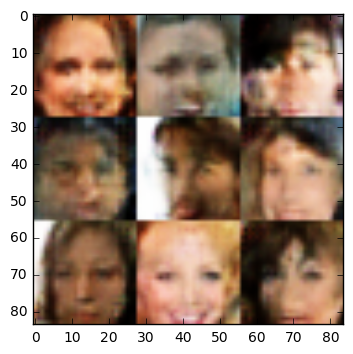

Epoch 1/1... Discriminator Loss: 0.7596 Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 0.9201 Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 0.7968 Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 0.4669 Generator Loss: 2.1371
Epoch 1/1... Discriminator Loss: 0.7650 Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.1992 Generator Loss: 1.1861
Epoch 1/1... Discriminator Loss: 0.9955 Generator Loss: 1.6234
Epoch 1/1... Discriminator Loss: 1.1032 Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 0.5134 Generator Loss: 1.3264
Epoch 1/1... Discriminator Loss: 1.1585 Generator Loss: 0.5511


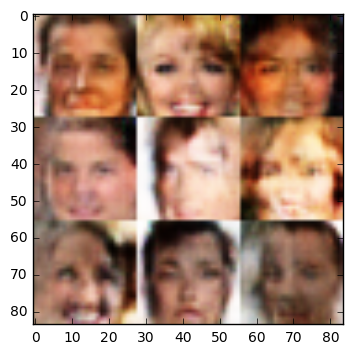

Epoch 1/1... Discriminator Loss: 1.1458 Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3070 Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 0.9822 Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 0.9921 Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 1.1941 Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 0.7557 Generator Loss: 2.1376
Epoch 1/1... Discriminator Loss: 1.2786 Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.3087 Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 0.6342 Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 1.5568 Generator Loss: 0.3591


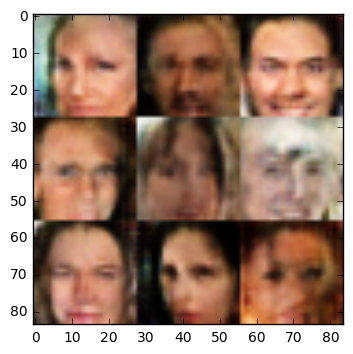

Epoch 1/1... Discriminator Loss: 0.7009 Generator Loss: 1.8168
Epoch 1/1... Discriminator Loss: 1.3370 Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.3626 Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.1336 Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.2902 Generator Loss: 0.4551
Epoch 1/1... Discriminator Loss: 1.2972 Generator Loss: 3.3405
Epoch 1/1... Discriminator Loss: 1.0994 Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3398 Generator Loss: 1.9566
Epoch 1/1... Discriminator Loss: 0.7818 Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 0.9616 Generator Loss: 1.1250


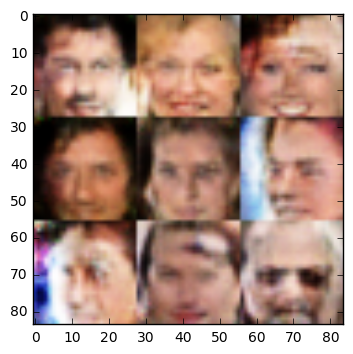

Epoch 1/1... Discriminator Loss: 0.6553 Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 0.8299 Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 0.7444 Generator Loss: 1.7255
Epoch 1/1... Discriminator Loss: 0.9402 Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 0.6401 Generator Loss: 1.1659
Epoch 1/1... Discriminator Loss: 0.9336 Generator Loss: 2.7274
Epoch 1/1... Discriminator Loss: 1.0031 Generator Loss: 2.5741
Epoch 1/1... Discriminator Loss: 1.1247 Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.1296 Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4071 Generator Loss: 0.4850


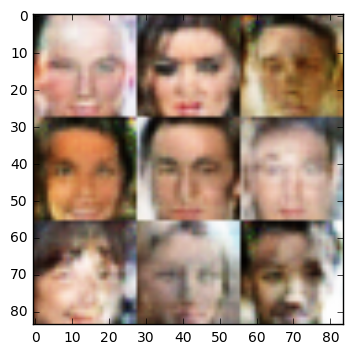

Epoch 1/1... Discriminator Loss: 1.3578 Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.4349 Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.0504 Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 0.5446 Generator Loss: 1.4606
Epoch 1/1... Discriminator Loss: 0.6901 Generator Loss: 1.1948
Epoch 1/1... Discriminator Loss: 0.9741 Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 0.9382 Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.3795 Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 0.5725 Generator Loss: 3.0954
Epoch 1/1... Discriminator Loss: 1.4368 Generator Loss: 0.5512


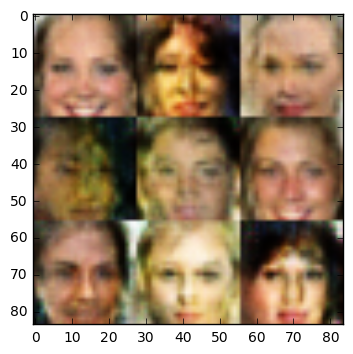

Epoch 1/1... Discriminator Loss: 1.5270 Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.2411 Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.0282 Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.1288 Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.2065 Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 0.8859 Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 0.9032 Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.1706 Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.3051 Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.3224 Generator Loss: 0.6435


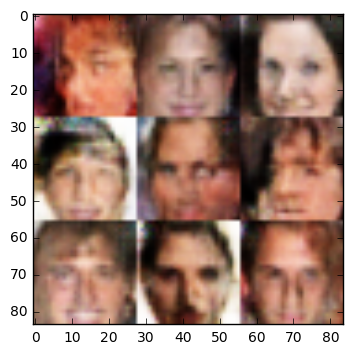

Epoch 1/1... Discriminator Loss: 1.2745 Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.1479 Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 0.7852 Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 0.7290 Generator Loss: 1.4386
Epoch 1/1... Discriminator Loss: 0.7485 Generator Loss: 1.9601
Epoch 1/1... Discriminator Loss: 0.9884 Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 0.9451 Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 0.6228 Generator Loss: 1.3804
Epoch 1/1... Discriminator Loss: 1.1712 Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 0.8894 Generator Loss: 1.2626


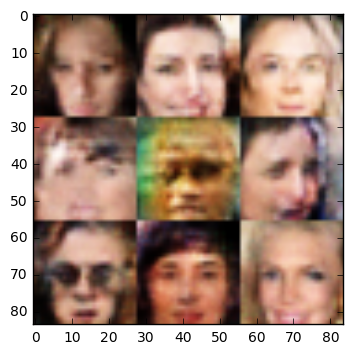

Epoch 1/1... Discriminator Loss: 0.7622 Generator Loss: 1.5426
Epoch 1/1... Discriminator Loss: 0.8441 Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.3305 Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 0.7905 Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.1482 Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 0.7815 Generator Loss: 2.2378
Epoch 1/1... Discriminator Loss: 0.4469 Generator Loss: 2.3365
Epoch 1/1... Discriminator Loss: 1.5760 Generator Loss: 0.3462
Epoch 1/1... Discriminator Loss: 1.2618 Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.0471 Generator Loss: 0.5958


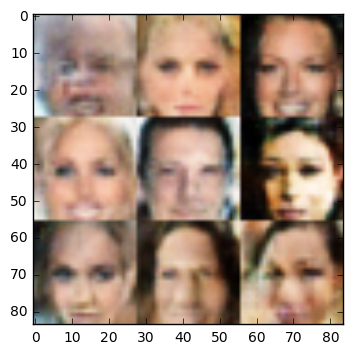

Epoch 1/1... Discriminator Loss: 1.5816 Generator Loss: 0.3029
Epoch 1/1... Discriminator Loss: 1.3154 Generator Loss: 0.4632
Epoch 1/1... Discriminator Loss: 1.1753 Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 0.8549 Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.1545 Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.0310 Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.0802 Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.3008 Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 0.8664 Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 0.8555 Generator Loss: 1.0158


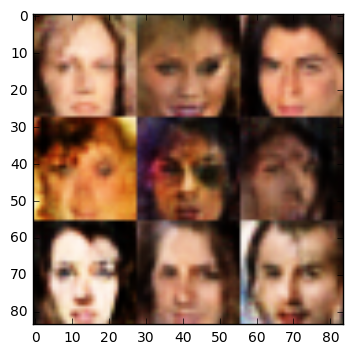

Epoch 1/1... Discriminator Loss: 1.5060 Generator Loss: 0.3312
Epoch 1/1... Discriminator Loss: 0.5259 Generator Loss: 2.0223
Epoch 1/1... Discriminator Loss: 1.1153 Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 0.9461 Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 0.9358 Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.1180 Generator Loss: 0.5808


In [168]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.